# Simple Bayesian Network

This notebook tries to assist to accomplish the following:
* Represent the different variables of a bayes network in a simple json like representation (not sure I am successful for that one)
* render this memory representation using Graphviz, showing the graph as well as associated probabilities
* compile a Bayes Model from that json representation.

This notebook is strongly inspired by the examples provided by the [pgmpy_notebook](https://github.com/pgmpy/pgmpy_notebook). 

To make sense of what is below, going through the exercise 1 and 2 of the pgmpy notebook is strongly suggested.
* [1. Introduction to Probabilistic Graphical Models](https://github.com/pgmpy/pgmpy_notebook/blob/master/notebooks/1.%20Introduction%20to%20Probabilistic%20Graphical%20Models.ipynb)
* [2. Bayesian Networks](https://github.com/pgmpy/pgmpy_notebook/blob/master/notebooks/2.%20Bayesian%20Networks.ipynb)

The Student Network used in this notebook come from the book of Daphne Koller, Nir Friedman. Probabilistic Graphical Models, Principles and Techniques, 2009, page 53

## Configuring the Bayesian Network

### Fill the structures

Each pairs from this list describes two nodes and the link between them. The graphviz helper uses this list to draw the graph and relations.

### Describe each variables

The "variables" describes each letter from the structures. At the first level, the description (desc) of the letter can be defined, as well as the legend of each value.

Note: 'cpd' means *Conditional Probability Distribution*. However, simple probabilities are also referred as 'cpd', like for the letter 'D' and 'I'. This is just to keep the code simple.
The numbers used for the index aren't used to address the proabilities later on. Numbers are used here for consistancy with the Student Network example.

In [1]:
structures = [('D', 'G'), ('I', 'G'), ('G', 'L'), ('I', 'S')]

variables = {
    'D': {
        'desc': "Difficulty",
        'legend': {0: 'Easy', 1: 'Hard'},
        'cpd': { 0: 0.4, 1: 0.6}
    },
    'I': {
        'desc': "Intelligence",
        'legend': {0: 'Dumb', 1: 'Intelligent'},
        'cpd': { 0: 0.7, 1: 0.3 }
    },
    'G': {
        'desc': "Grade",
        'legend': { 0:'A', 1:'B', 2:'C' },
        'cpd': {
            0: { 'I': { 0: { 'D': { 0: 0.3, 1: 0.05 } },
                        1: { 'D': { 0: 0.9, 1: 0.5 } } } },
            1: { 'I': { 0: { 'D': { 0: 0.4, 1: 0.25 } },
                        1: { 'D': { 0: 0.08, 1: 0.3 } } } },
            2: { 'I': { 0: { 'D': { 0: 0.3, 1: 0.7 } },
                        1: { 'D': { 0: 0.02, 1: 0.2 } } } },
        }
    },
    'L': {
        'desc': "Letter",
        'legend': { 0:'Bad', 1:'Good' },
        'cpd': {
            0: { 'G': { 0: 0.1, 1: 0.4, 2: 0.99 } },
            1: { 'G': { 0: 0.9, 1: 0.6, 2: 0.01 } }
        }
    },
    'S':{
        'desc': "SAT",
        'legend': { 0:'Bad', 1:'Good' },
        'cpd': {
            0: { 'I': { 0: 0.95, 1: 0.2 } },
            1: { 'I': { 0: 0.05, 1: 0.8} }
        }
    }
}

## Render the Graphical Representation of the Bayes Network

Everything here is done in the background by the graphviz_helper

In [2]:
%load_ext autoreload
%autoreload 2

from graphviz_helper import render_graph
from graphviz_helper import render_graph_probabilities

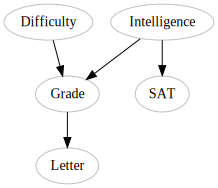

In [3]:
g = render_graph(structures, variables)

g

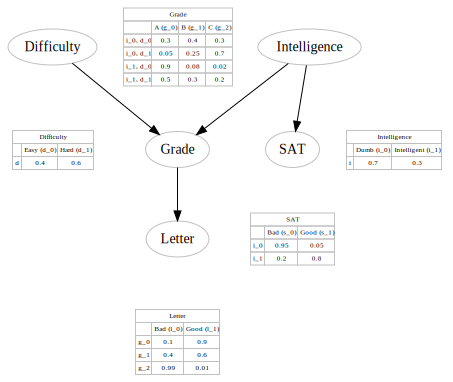

In [4]:
g = render_graph_probabilities(g, variables)

g

## Build the Bayes Network Model With pgmpy

Building the model is done in the background by the graphviz_helper.

Once built, the model can be queried.

In [5]:
from graphviz_helper import build_BayesianModel

# Defining the model structure. We can define the network by just passing a list of edges.
model = build_BayesianModel(structures, variables)

model.check_model()

adding cpd_d
adding cpd_i
adding cpd_g
adding cpd_l
adding cpd_s


True

In [6]:
model.get_cpds()

[<TabularCPD representing P(D:2) at 0x10af19898>,
 <TabularCPD representing P(I:2) at 0x10af19668>,
 <TabularCPD representing P(G:3 | I:2, D:2) at 0x10af19940>,
 <TabularCPD representing P(L:2 | G:3) at 0x10bc3cc50>,
 <TabularCPD representing P(S:2 | I:2) at 0x10bc3ccc0>]

## Printing the CPD for a node

pgmpy allows us to display the probabilities associated with a variable. Here we are looking at the grade. Notice that pgmpy rotates the graph

In [7]:
print(model.get_cpds('G'))

╒═════╤═════╤══════╤══════╤═════╕
│ I   │ I_0 │ I_0  │ I_1  │ I_1 │
├─────┼─────┼──────┼──────┼─────┤
│ D   │ D_0 │ D_1  │ D_0  │ D_1 │
├─────┼─────┼──────┼──────┼─────┤
│ G_0 │ 0.3 │ 0.05 │ 0.9  │ 0.5 │
├─────┼─────┼──────┼──────┼─────┤
│ G_1 │ 0.4 │ 0.25 │ 0.08 │ 0.3 │
├─────┼─────┼──────┼──────┼─────┤
│ G_2 │ 0.3 │ 0.7  │ 0.02 │ 0.2 │
╘═════╧═════╧══════╧══════╧═════╛


We can rotate the values to display them in a normal fashion by using the following. However, we lose the column headers and row descriptions.

In [8]:
print(model.get_cpds('G').values.T)
# print(model.get_cardinality('I'))


[[[0.3  0.4  0.3 ]
  [0.9  0.08 0.02]]

 [[0.05 0.25 0.7 ]
  [0.5  0.3  0.2 ]]]


In [9]:
# Getting all the local independencies in the network.
model.local_independencies(['D', 'I', 'S', 'G', 'L'])

(D _|_ G, S, L, I)
(I _|_ G, S, L, D)
(S _|_ G, L, D | I)
(G _|_ S, L | I, D)
(L _|_ I, S, D | G)

In [10]:
# Active trail: For any two variables A and B in a network if any change in A influences the values of B then we say
#               that there is an active trail between A and B.
# In pgmpy active_trail_nodes gives a set of nodes which are affected by any change in the node passed in the argument.
model.active_trail_nodes('D')

{'D': {'D', 'G', 'L'}}

In [11]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)
print(infer.query(['G']) ['G'])

╒═════╤══════════╕
│ G   │   phi(G) │
╞═════╪══════════╡
│ G_0 │   0.3030 │
├─────┼──────────┤
│ G_1 │   0.2806 │
├─────┼──────────┤
│ G_2 │   0.4164 │
╘═════╧══════════╛


## Ok, now what? What can we do with this graph?

Now that we have a fully parametrised network, we can ask questions.

We observe that the test was not difficult (D:0), and we know that the student is intelligent (I:1)

* Q1. What is the probability that the student gets a A (G_0)?
* Q2: What is the likelihood that the student gets a letter of recommendation? (L_1)?
* Q3: What is the likelihood that the student gets a got SAT score?

In [12]:
query_variable = ['G' ,'L', 'S']
evidence = {
    'D': 0, 
    'I': 1
}

for q in query_variable:
    if q not in evidence.keys():
        print((infer.query([q], evidence=evidence) [q]))
        print((infer.query([q], evidence=evidence) [q]).values)
    else:
        print("{} is observed as {}".format(q,evidence[q]))

╒═════╤══════════╕
│ G   │   phi(G) │
╞═════╪══════════╡
│ G_0 │   0.9000 │
├─────┼──────────┤
│ G_1 │   0.0800 │
├─────┼──────────┤
│ G_2 │   0.0200 │
╘═════╧══════════╛
[0.9  0.08 0.02]
╒═════╤══════════╕
│ L   │   phi(L) │
╞═════╪══════════╡
│ L_0 │   0.1418 │
├─────┼──────────┤
│ L_1 │   0.8582 │
╘═════╧══════════╛
[0.1418 0.8582]
╒═════╤══════════╕
│ S   │   phi(S) │
╞═════╪══════════╡
│ S_0 │   0.2000 │
├─────┼──────────┤
│ S_1 │   0.8000 │
╘═════╧══════════╛
[0.2 0.8]


## Predicting values from new data points

Let's say that we don't care about the probability itself, we just want to know which is the most likely outcome for each variable.

Predicting values from new data points is quite similar to computing the conditional probabilities. We need to query for the variable that we need to predict given all the other features. The only difference is that rather than getting the probabilitiy distribution we are interested in getting the most probable state of the variable.

In pgmpy this is known as MAP query. 

Here's an example if we don't have evidence:

In [15]:
# What is the most probable value for the variables `query_variable`, if we don't provide evidence?
infer.map_query(query_variable)

{'G': 2, 'L': 0, 'S': 0}

Same query, but with evidences:

In [14]:
# What is the most probable value for the variables `query_variable`, given evidences `evidence`?
infer.map_query(query_variable, evidence=evidence)

{'G': 0, 'L': 1, 'S': 1}